# Detrending using piecewise linear regression + temperature for seasonality removal

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
bikeshare = pd.read_csv('./bikeshare_train_data.csv',parse_dates=['Date'])

In [4]:
temp_reg = LinearRegression()
temp_reg.fit(bikeshare.max_temp.values.reshape(-1,1),
            bikeshare.num_trips)
temp_preds = temp_reg.predict(bikeshare.max_temp.values.reshape(-1,1))

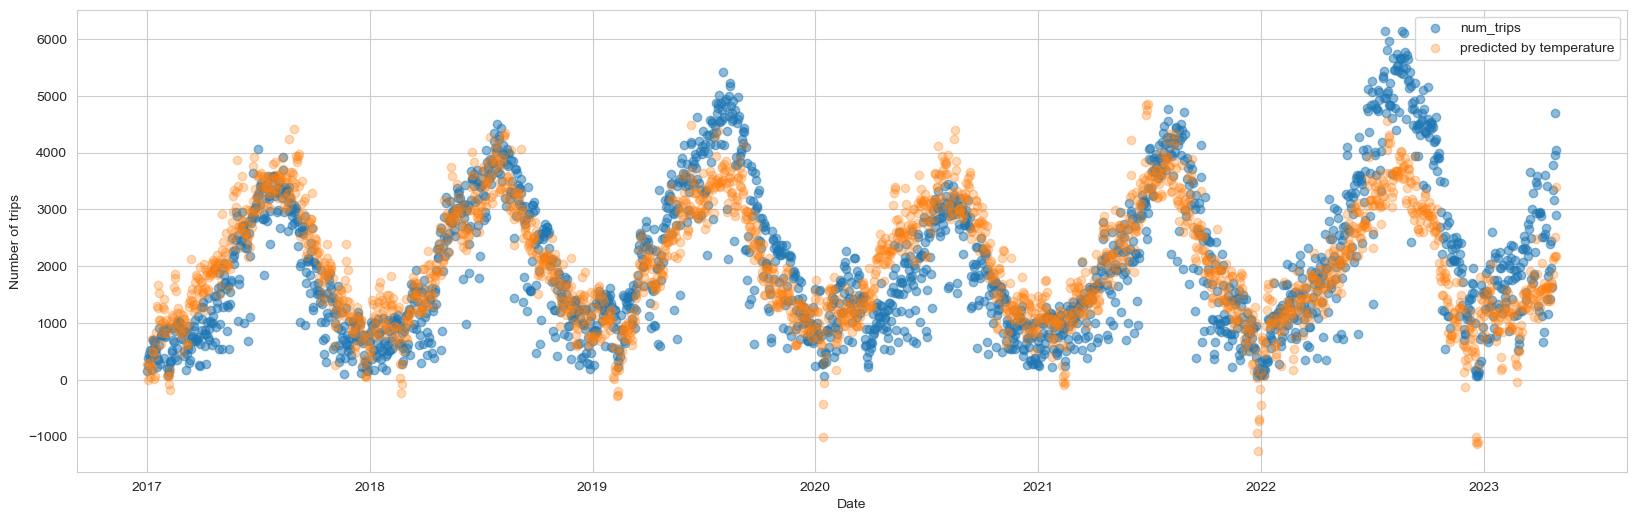

In [5]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           bikeshare.num_trips,
           alpha=0.5,
           label='num_trips')

plt.scatter(bikeshare.Date,
           temp_preds,
           alpha=0.3,
           label='predicted by temperature')

plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.legend()

plt.show()

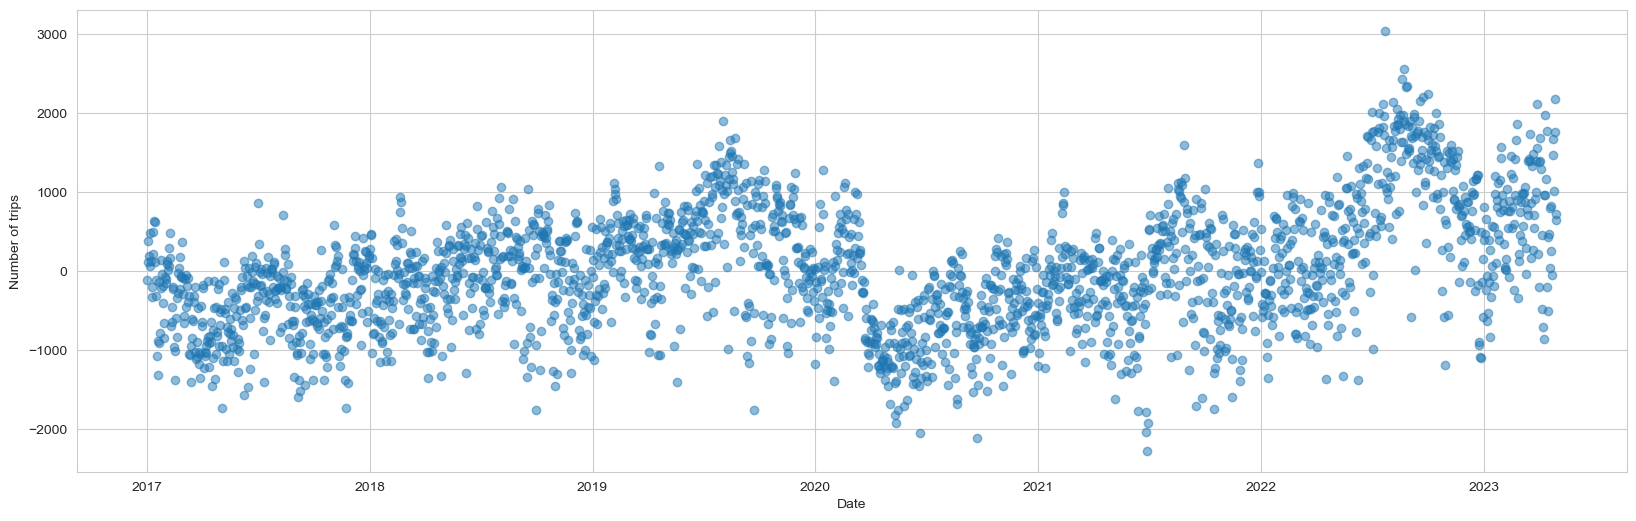

In [6]:
temp_residuals = bikeshare.num_trips - temp_preds

plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           temp_residuals,
           alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Number of trips')


plt.show()

So ``max_temp`` accounts for the seasonality, and we can figure out the trend from the above plot.

In [7]:
bikeshare['temp_residuals'] = temp_residuals
date1 = pd.Timestamp(year=2020,month=2,day=1)
date2 =  pd.Timestamp(year=2020,month=4,day=1)
bikeshare_piece1 = bikeshare.loc[bikeshare.Date < date1]
bikeshare_piece2 = bikeshare.loc[bikeshare.Date >= date2]

piece1_reg = LinearRegression()
piece1_reg.fit(bikeshare_piece1.index.values.reshape(-1,1),
               bikeshare_piece1.temp_residuals)

piece2_reg = LinearRegression()
piece2_reg.fit(bikeshare_piece2.index.values.reshape(-1,1),
               bikeshare_piece2.temp_residuals)

piece1_preds = piece1_reg.predict(bikeshare_piece1.index.values.reshape(-1,1))
piece2_preds = piece2_reg.predict(bikeshare_piece2.index.values.reshape(-1,1))

In [8]:
bikeshare_interim = bikeshare.loc[(bikeshare.Date >= date1) & (bikeshare.Date < date2)]
interim_reg = LinearRegression()
interim_reg.fit(bikeshare_interim.index.values.reshape(-1,1),
               bikeshare_interim.temp_residuals)
interim_preds = interim_reg.predict(bikeshare_interim.index.values.reshape(-1,1))

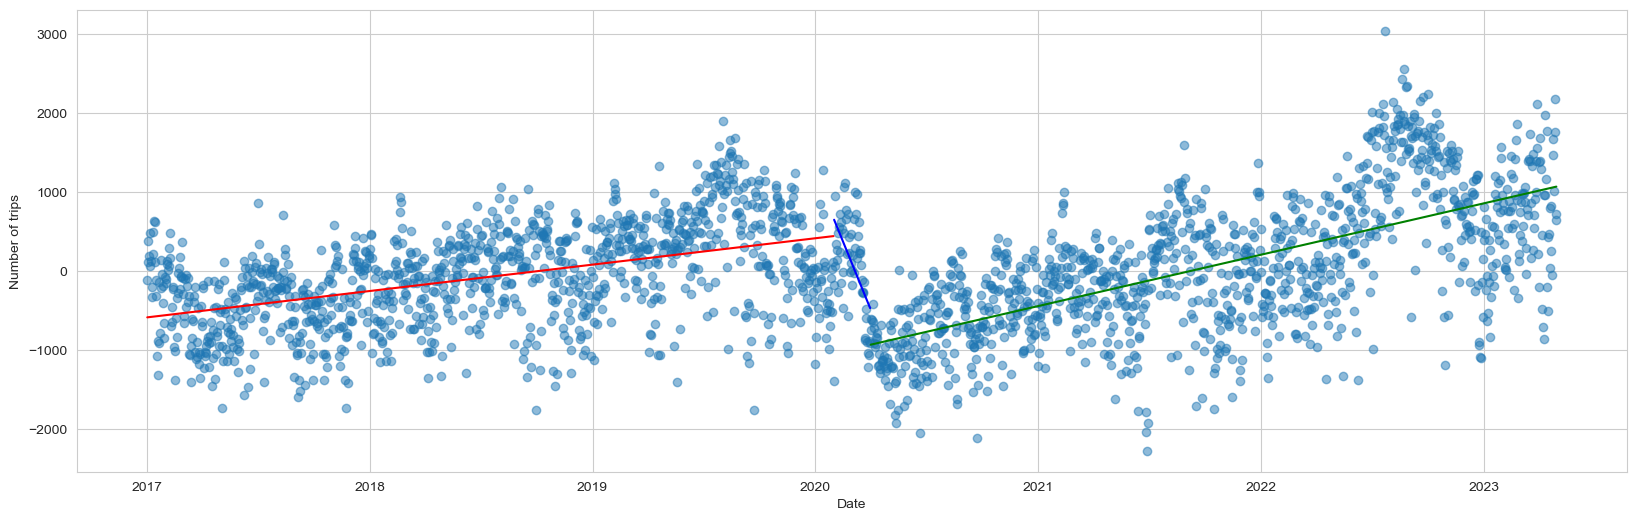

In [9]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           temp_residuals,
           alpha=0.5)

plt.plot(bikeshare_piece1.Date,
        piece1_preds,
        'r-')

plt.plot(bikeshare_interim.Date,
        interim_preds,
        'b')

plt.plot(bikeshare_piece2.Date,
        piece2_preds,
        'g-')

plt.xlabel('Date')
plt.ylabel('Number of trips')


plt.show()

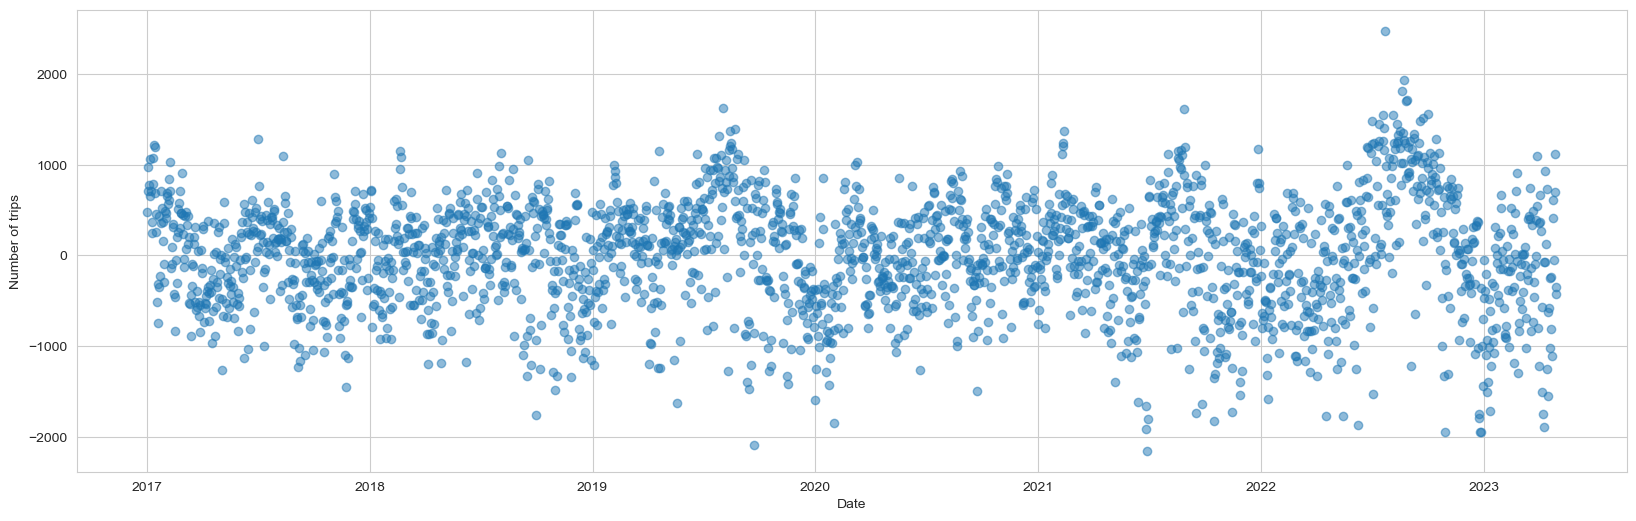

In [10]:
piecewise_preds = np.concatenate((piece1_preds, interim_preds, piece2_preds))
total_residuals = temp_residuals - piecewise_preds

plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           total_residuals,
           alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Number of trips')


plt.show()

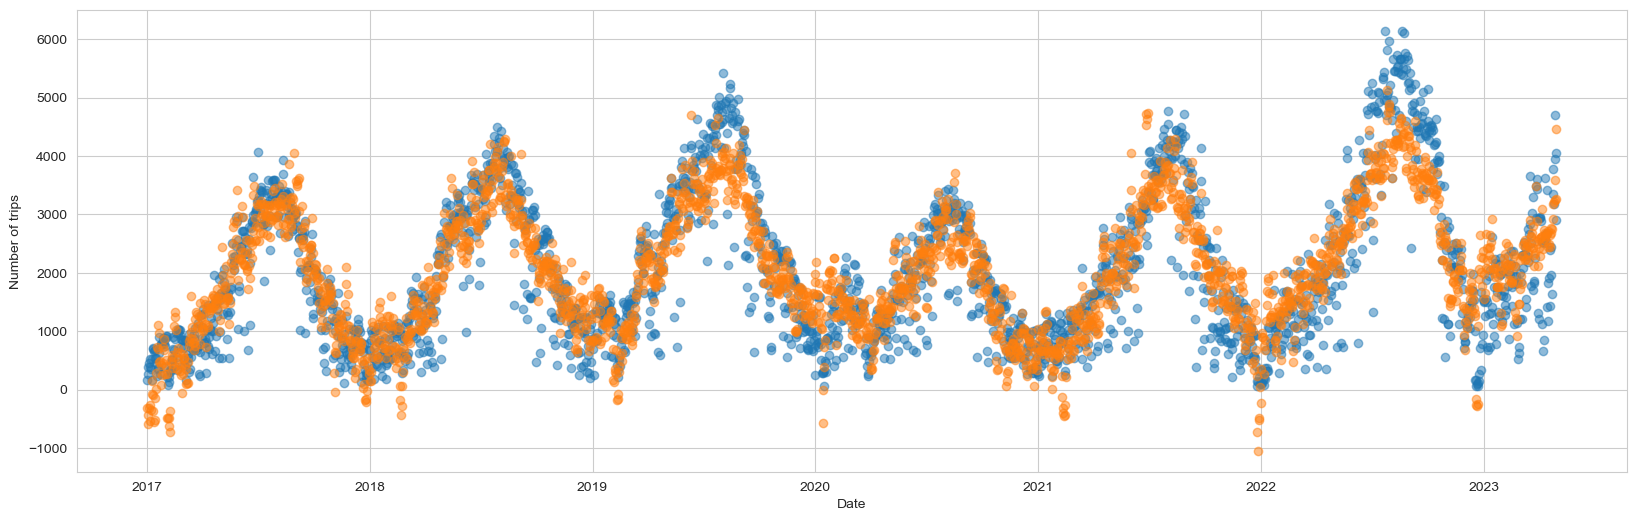

In [11]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           bikeshare.num_trips,
           alpha=0.5,
           label='num_trips')

plt.scatter(bikeshare.Date,
           piecewise_preds + temp_preds,
           alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Number of trips')


plt.show()

So, ``piecewise_preds`` is the demand trend we can use. For future forecasting and predictions based on weather past 2023-05, just add on predictions from ``piece2_reg``.

In [12]:
bikeshare['adj_num_trips'] = bikeshare.num_trips - piecewise_preds
bikeshare.adj_num_trips += np.abs(bikeshare.iloc[np.argmin(bikeshare.adj_num_trips)].adj_num_trips)

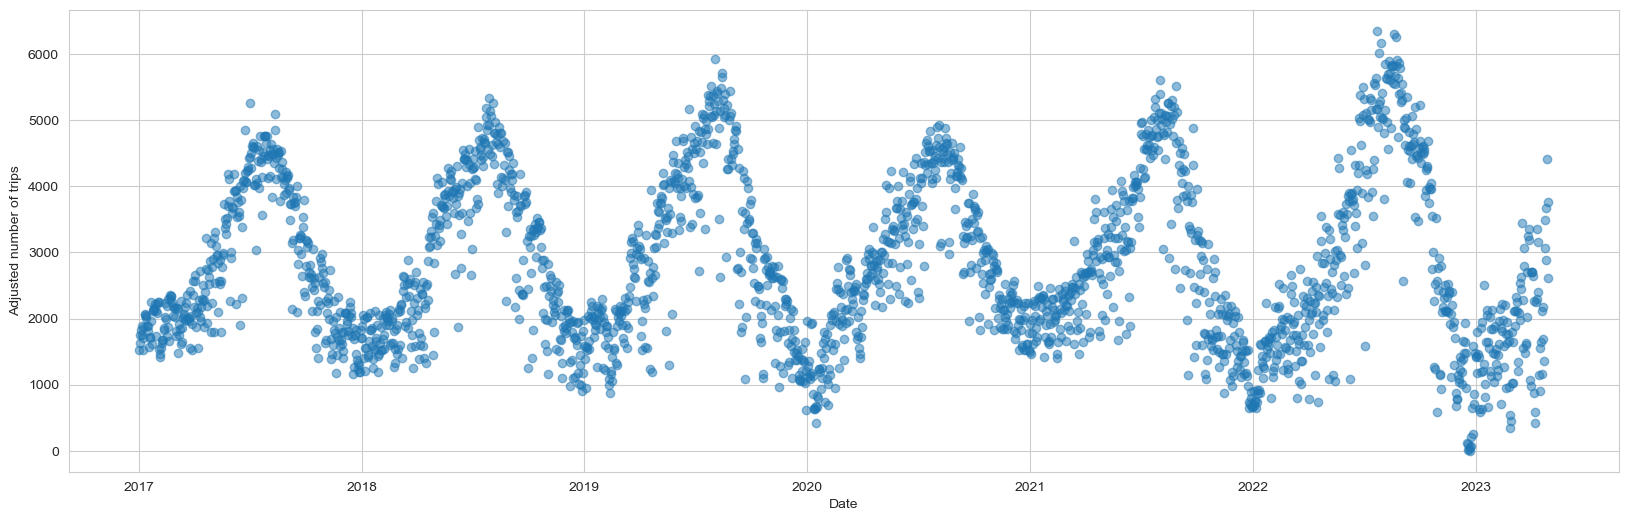

In [13]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           bikeshare.adj_num_trips,
           alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Adjusted number of trips')


plt.show()

In [14]:
bikeshare = bikeshare.drop('temp_residuals',axis=1)
bikeshare.to_csv('bikeshare_train_data_pcwsdetrend.csv', index=False, index_label='Date')

# Applying this transformation to test data

In [15]:
bikeshare_test = pd.read_csv('./bikeshare_test_data.csv',parse_dates=['Date'])
bikeshare_test['adj_num_trips'] = np.nan
bikeshare_test

,Date,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,...,snow_on_ground,max_gust,mean_dep_temp,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips,adj_num_trips
0,2023-05-01,878.233333,8.2,14.30,11.30,6.10,6.70,0.0,0.0,0.0,...,0.0,13.0,16.219982,16.459525,16.339753,8845978.00,4189598.0,940.0,3323,NaN
1,2023-05-02,881.233333,9.2,16.90,13.10,7.70,4.90,0.0,0.0,0.0,...,0.0,5.0,20.282667,20.327604,20.305136,14330668.34,6003918.0,1415.0,4829,NaN
2,2023-05-03,884.233333,11.4,18.70,15.10,7.30,2.90,0.0,0.0,0.0,...,0.0,14.0,21.942356,21.817669,21.880013,14161604.00,6968794.0,1384.0,4788,NaN
3,2023-05-04,887.233333,11.7,19.10,15.40,7.40,2.60,0.0,0.0,0.0,...,0.0,17.0,20.105866,19.945234,20.025550,12494360.00,6720056.0,1289.0,4364,NaN
4,2023-05-05,890.233333,9.8,12.40,11.10,2.60,6.90,0.0,15.6,0.0,...,0.0,19.0,11.744112,12.386378,12.065245,3639263.67,1390702.0,472.0,1571,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2024-04-26,864.233333,8.7,14.60,11.70,5.90,6.30,0.0,6.6,0.0,...,0.0,0.0,13.858925,14.667360,14.263142,9459383.33,4193707.0,1346.0,3367,NaN
362,2024-04-27,867.233333,8.8,11.10,10.00,2.30,8.00,0.0,6.8,0.0,...,0.0,9.0,10.175058,10.984508,10.579783,3274519.00,1443072.0,547.0,1291,NaN
363,2024-04-28,870.233333,7.9,12.80,10.40,4.90,7.60,0.0,0.5,0.0,...,0.0,15.0,11.309987,11.947687,11.628837,6738587.00,2859352.0,851.0,2313,NaN
364,2024-04-29,874.233333,6.5,12.75,9.65,6.25,8.35,0.0,0.0,0.0,...,0.0,6.0,14.148129,14.511835,14.329982,11560811.99,4935558.0,1467.0,3929,NaN


In [16]:
bikeshare_total = pd.concat((bikeshare, bikeshare_test), ignore_index=True)
bikeshare_total

,Date,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,...,snow_on_ground,max_gust,mean_dep_temp,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips,adj_num_trips
0,2017-01-01,497.133333,-2.3,2.20,-0.10,4.50,18.10,0.0,0.0,0.0,...,3.0,10.0,3.555556,4.296296,3.925926,338025.00,232693.0,0.0,162,1527.427005
1,2017-01-02,498.133333,-6.0,1.40,-2.30,7.40,20.30,0.0,0.0,0.0,...,2.0,0.0,2.718519,3.688889,3.203704,660054.00,382729.0,0.0,270,1634.511236
2,2017-01-03,499.133333,-7.8,0.40,-3.70,8.20,21.70,0.0,0.0,0.0,...,1.0,0.0,0.807292,1.791667,1.299479,635395.00,376013.0,0.0,384,1747.595467
3,2017-01-04,501.133333,-8.4,2.20,-3.10,10.60,21.10,0.0,0.0,0.0,...,1.0,1.0,2.767391,3.643478,3.205435,766082.00,376721.0,0.0,460,1822.679699
4,2017-01-05,502.133333,-6.6,0.70,-3.00,7.30,21.00,0.0,0.0,0.0,...,1.0,0.0,2.601145,3.524809,3.062977,888222.00,524933.0,0.0,524,1885.763930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,2024-04-26,864.233333,8.7,14.60,11.70,5.90,6.30,0.0,6.6,0.0,...,0.0,0.0,13.858925,14.667360,14.263142,9459383.33,4193707.0,1346.0,3367,NaN
2673,2024-04-27,867.233333,8.8,11.10,10.00,2.30,8.00,0.0,6.8,0.0,...,0.0,9.0,10.175058,10.984508,10.579783,3274519.00,1443072.0,547.0,1291,NaN
2674,2024-04-28,870.233333,7.9,12.80,10.40,4.90,7.60,0.0,0.5,0.0,...,0.0,15.0,11.309987,11.947687,11.628837,6738587.00,2859352.0,851.0,2313,NaN
2675,2024-04-29,874.233333,6.5,12.75,9.65,6.25,8.35,0.0,0.0,0.0,...,0.0,6.0,14.148129,14.511835,14.329982,11560811.99,4935558.0,1467.0,3929,NaN


In [17]:
test_preds = piece2_reg.predict(bikeshare_total.index.values.reshape(-1,1)[-len(bikeshare_test):])

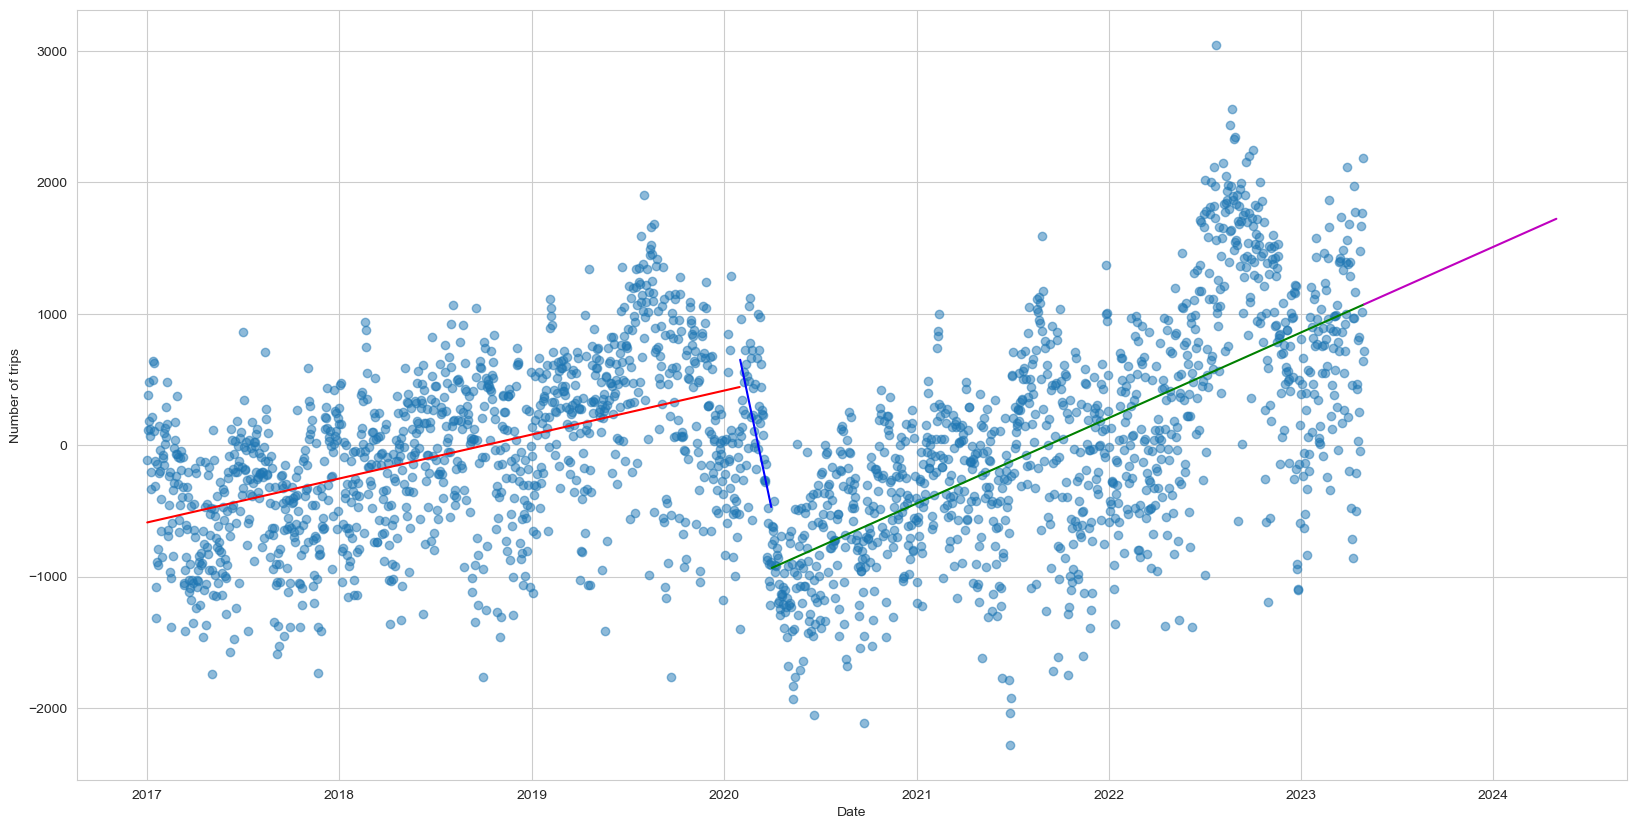

In [18]:
plt.figure(figsize=(20,10))

plt.scatter(bikeshare.Date,
           temp_residuals,
           alpha=0.5)

plt.plot(bikeshare_piece1.Date,
        piece1_preds,
        'r-')

plt.plot(bikeshare_interim.Date,
        interim_preds,
        'b')

plt.plot(bikeshare_piece2.Date,
        piece2_preds,
        'g-')

plt.plot(bikeshare_test.Date,
        test_preds,
        'm-')

plt.xlabel('Date')
plt.ylabel('Number of trips')


plt.show()

In [19]:
#piecewise_preds = np.concatenate((piece1_preds, interim_preds, piece2_preds, test_preds))
bikeshare_test['adj_num_trips'] = bikeshare_test.num_trips - test_preds
bikeshare_test.adj_num_trips += np.abs(bikeshare.iloc[np.argmin(bikeshare.adj_num_trips)].adj_num_trips)

In [20]:
bikeshare_test.to_csv('bikeshare_test_data_pcwsdetrend.csv', index=False, index_label='Date')

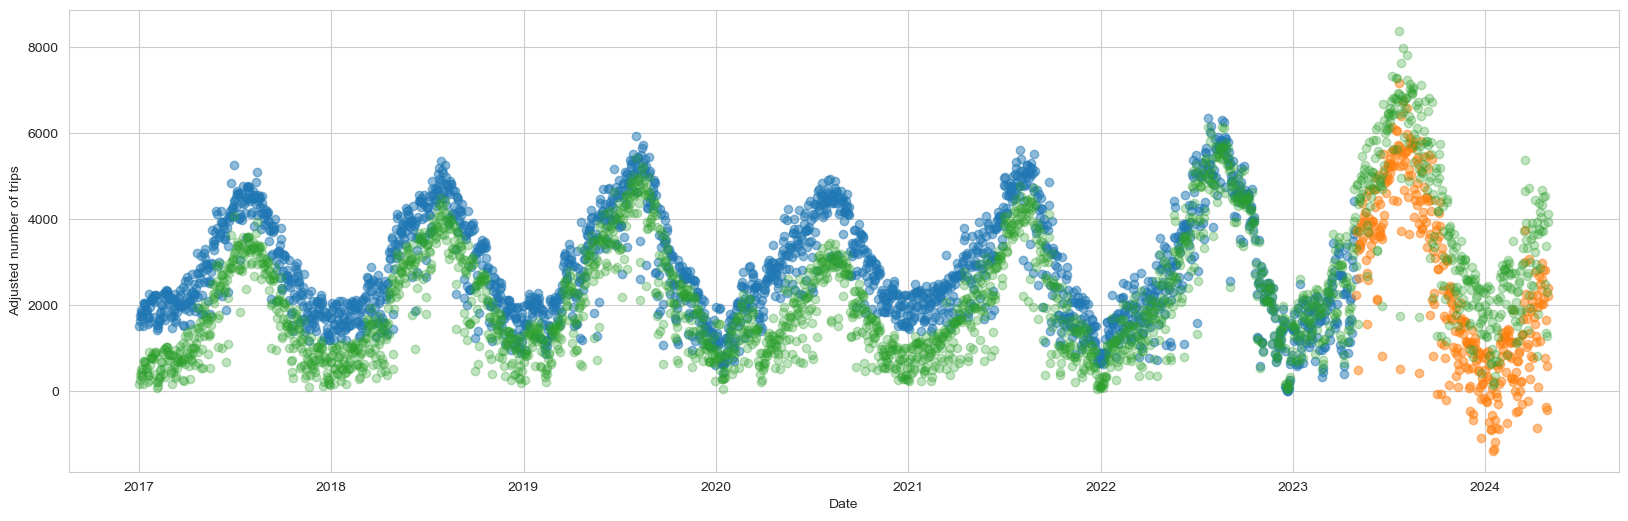

In [22]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           bikeshare.adj_num_trips,
           alpha=0.5)

plt.scatter(bikeshare_test.Date,
           bikeshare_test.adj_num_trips,
           alpha=0.5)

plt.scatter(bikeshare_total.Date,
            bikeshare_total.num_trips,
            alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Adjusted number of trips')


plt.show()